# Projet de Deep Learning :


=========== projet 6: prediction série temporelle =========

Nous considérons une série temporelle financière donnée de longueur totale N, S_t, t=0,1,...,N.
Nt=0.8*N (entrainement), Nv=0.2*N (validation) à télécharger sur internet ou à prendre une colonne dans 
https://turinici.com/wp-content/uploads/cours/common/close_cac40_historical.csv

Exemple N=255*10 (10 années de données journalières)

On calcule pour chaque point de la série initiale 
- les rendements R_t = np.log(X_t/X_{t-1})
- la moyenne des K derniers rendements, K=5 (=1 semaine: 1W), K=25 (1 mois: 1M), K=3*25 (3M); K=6*25 (6M), K=255 (1Y), K=3Y
- la volatilité (annualisée) des K derniers rendements sur la même période

On ajoute pour chaque point : 
- les calculs précédents (1+7*2 = 15 données)
- le prix en 't', (1 donnée)
- la moyenne exponentielle (EMA) des derniers K prix divisé par le prix en t (7 données)
- une fenetre de longueur "n" des prix S_{t-n} ... S_t,  par exemple n=3*25 (3 mois) : n données .

Attention: parfois il n'est pas possible de calculer par exemple la moyenne sur les 3 dernières année car pas assez de données. Alors la prendre égale à la plus longue qu'il est possible de calculer (ne pas mettre "nan").

Donc la base de données contient N-1 points.
A prevoir: le rendement suivant en R_{t+1}


In [ ]:
# 0) Chargement des bibliothèques + seed
# --------------------------------------

import numpy as np
import pandas as pd
import pandas_ta as ta

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os

# Pour la régression linéaire
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Pour le réseau de neurones (Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from tabulate import tabulate

# Fixation du seed pour la reproductibilité
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Libraries loaded and random seed fixed.")


Libraries loaded and random seed fixed.


# 1) Lecture des données (depuis l'URL) et prétraitement

In [42]:
# URL des données
url = "https://turinici.com/wp-content/uploads/cours/common/close_cac40_historical.csv"

# Lecture du fichier CSV en ne chargeant que la colonne 'BNP.PA'
df_raw = pd.read_csv(url, sep=";", usecols=["Date", "BNP.PA"])

# Renommage des colonnes 
df_raw.rename(columns={"BNP.PA": "Price"}, inplace=True)

# Conversion de la colonne 'Date' en format datetime 
df_raw['Date'] = pd.to_datetime(df_raw['Date'])

# Définir la colonne 'Date' comme index
df_raw.set_index("Date", inplace=True)

print("\nAperçu des premières lignes :")
display(df_raw.head())
print("\nDimensions initiales :", df_raw.shape)

df_raw.dropna(subset=["Price"], inplace=True)

# Tri par index (date) pour s'assurer de l'ordre chronologique
df_raw.sort_index(inplace=True)

print("\nAperçu après nettoyage :")
display(df_raw.head())
print("\nDimensions après nettoyage :", df_raw.shape)




Aperçu des premières lignes :


,Price
Date,
2000-01-03,16.165972
2000-01-04,15.711578
2000-01-05,15.379528
2000-01-06,14.855226
2000-01-07,15.047465



Dimensions initiales : (8605, 1)

Aperçu après nettoyage :


,Price
Date,
1993-10-18,4.227787
1993-10-19,4.120383
1993-10-20,4.149676
1993-10-21,4.218023
1993-10-22,4.315662



Dimensions après nettoyage : (7339, 1)


# 2) Feature Engineering

In [43]:
# - Calcul des rendements log (R_t = log(X_t / X_{t-1}))
# - Moyennes mobiles sur K jours, volatilités annualisées
# - EMA (Exponentially Moving Average) / Price
# - Fenêtre glissante n = 3 * 25

df = df_raw.copy()

# 2.1 Calcul du rendement log
df["Return"] = np.log(df["Price"] / df["Price"].shift(1))
df = df.dropna()  # Retirer la première ligne NaN

# 2.2 Définition des horizons K
K_list = [5, 25, 75, 150, 252, 3*252]  # 1W, 1M, 3M, 6M, 1Y, 3Y
K_list = [K for K in K_list if K < len(df)]  # Filtrage pour les bases courtes

# Calcul des moyennes mobiles et volatilités annualisées
for K in K_list:
    df[f"meanRet_{K}"] = df["Return"].rolling(K).mean()
    df[f"meanRet_{K}"] = df[f"meanRet_{K}"].bfill()  

    df[f"vol_{K}"] = df["Return"].rolling(K).std() * np.sqrt(252)
    df[f"vol_{K}"] = df[f"vol_{K}"].bfill()  

# 2.4 EMA(K) / Price
for K in K_list:
    ema_series = df["Price"].ewm(span=K, adjust=False).mean()
    df[f"emaRatio_{K}"] = ema_series / df["Price"]
    df[f"emaRatio_{K}"] = df[f"emaRatio_{K}"].bfill()  

# 2.5 Fenêtre glissante
n = 25 * 3
for i in range(n):
    df[f"Price_lag_{i+1}"] = df["Price"].shift(i+1)

df = df.dropna()  

# 2.6 Cible = Rendement futur R_{t+1}
df["FutureReturn"] = df["Return"].shift(-1)
df = df.dropna()  

print(f"\nDimensions après feature engineering : {df.shape}")

# 2.7 Sélection des features (X) et de la cible (y)
exclude_cols = ["Price", "Return", "FutureReturn"]
feature_cols = [c for c in df.columns if c not in exclude_cols]
X = df[feature_cols].values
y = df["FutureReturn"].values

# 2.8 Normalisation (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature scaling terminé.")


Dimensions après feature engineering : (7262, 96)
Feature scaling terminé.


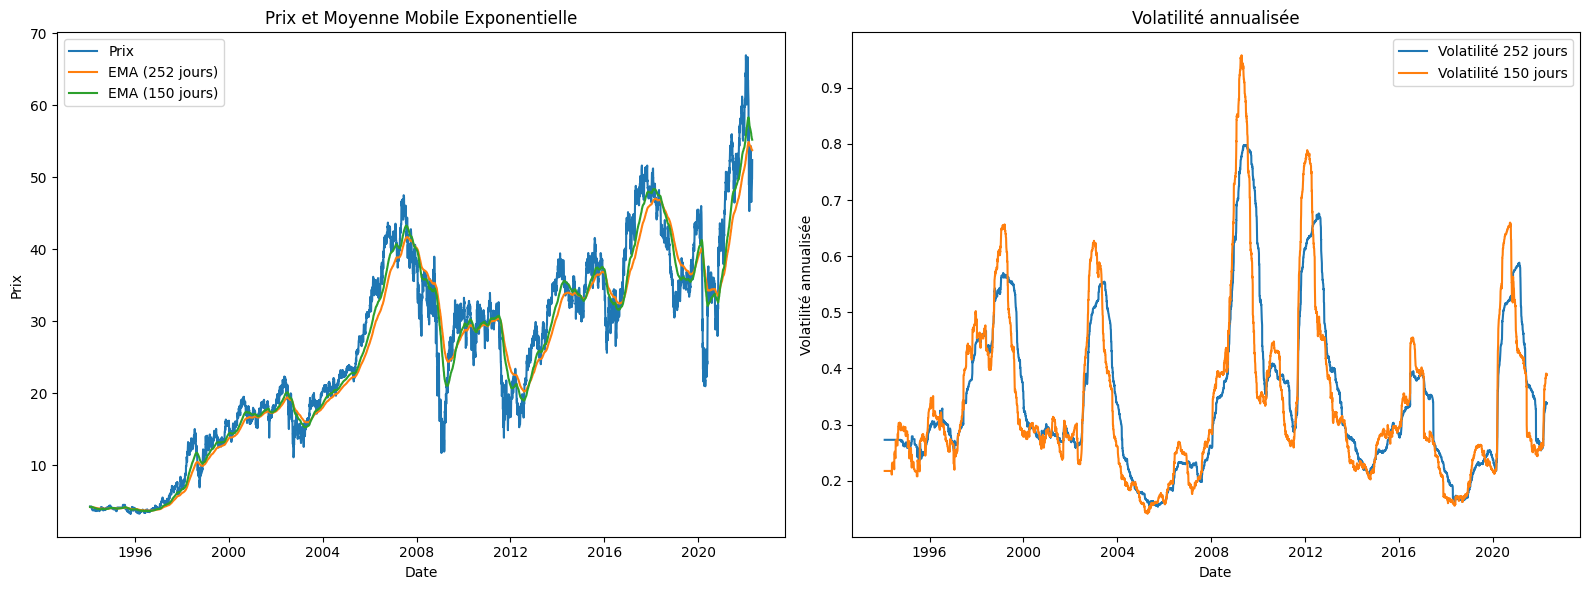

In [45]:
plt.figure(figsize=(16, 6))

# Sous-graphe 1 : Prix et EMA
plt.subplot(1, 2, 1)  
plt.plot(df.index, df["Price"], label="Prix")
plt.plot(df.index, df["Price"] * df["emaRatio_252"], label="EMA (252 jours)")
plt.plot(df.index, df["Price"] * df["emaRatio_150"], label="EMA (150 jours)")
plt.title("Prix et Moyenne Mobile Exponentielle")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()

# Sous-graphe 2 : Volatilité annualisée
plt.subplot(1, 2, 2)  
for K in [252, 150]:  
    plt.plot(df.index, df[f"vol_{K}"], label=f"Volatilité {K} jours")
plt.title("Volatilité annualisée")
plt.xlabel("Date")
plt.ylabel("Volatilité annualisée")
plt.legend()

plt.tight_layout()
plt.show()


# 3) Séparation temporelle (Train=80%, Test=20%)


In [46]:
N = len(df)
Nt = int(0.8 * N)   # Nt := N_Train
Nv = N - Nt # Nv := N_Test

X_train, X_test = X_scaled[:Nt], X_scaled[Nt:]
y_train, y_test = y[:Nt], y[Nt:]

print("\nTaille dataset complet :", N)
print("Taille train :", Nt)
print("Taille test :", Nv)


Taille dataset complet : 7262
Taille train : 5809
Taille test : 1453


# 4.1) Modèle de Regression Linéaire 

In [11]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)

mse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
print(f"\nRégression Linéaire - RMSE test : {mse_lin:.6f}")



Régression Linéaire - RMSE test : 0.021756


In [ ]:
errors = np.array(y_test) - np.array(y_pred_lin)

fig = go.Figure()

# Ajout des vrais rendements
fig.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test,
    mode='lines+markers',
    name='Vrais rendements (Réels)',
    line=dict(color='blue', dash='solid'),
    marker=dict(symbol='circle'),
    opacity=0.7
))

# Ajout des prédictions
fig.add_trace(go.Scatter(
    x=list(range(len(y_pred_lin))),
    y=y_pred_lin,
    mode='lines+markers',
    name='Prédictions (Régression Linéaire)',
    line=dict(color='red', dash='dash'),
    marker=dict(symbol='x'),
    opacity=0.7
))

# Ajout des erreurs
fig.add_trace(go.Scatter(
    x=list(range(len(errors))),
    y=errors,
    mode='lines+markers',
    name='Erreur (Vrais - Prédictions)',
    line=dict(color='green', dash='dot'),
    marker=dict(symbol='triangle-up'),
    opacity=0.7
))

fig.update_layout(
    title="Vrais rendements VS Prédictions et Erreur (Régression Linéaire)",
    xaxis_title="Index Chronologique",
    yaxis_title="Rendement",
    legend=dict(font=dict(size=12)),
    grid=dict(rows=1, columns=1),
    template="plotly_white"
)

fig.show()


# 4.1) Modèle de Regression Linéaire Pénalisation Lasso

In [15]:
lasso = Lasso(alpha=0.01)  
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# Évaluation des performances pour Lasso
mse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f"\nRégression Lasso - RMSE test : {mse_lasso:.6f}")

'''print("\nComparaison des coefficients :")
print("Régression Linéaire :", linreg.coef_)
print("Régression Lasso :", lasso.coef_)'''

coefficients_linreg = pd.Series(linreg.coef_, index=df[feature_cols].columns)
coefficients_linreg = coefficients_linreg.abs()
coefficients_linreg = coefficients_linreg.sort_values(ascending=False)
coefficients_lasso = pd.Series(lasso.coef_, index=df[feature_cols].columns)
coefficients_lasso = coefficients_lasso.abs()
coefficients_lasso = coefficients_lasso.sort_values(ascending=False)
print("Important features in the linear regression :",coefficients_linreg)
print("Important features in the lasso regression :",coefficients_lasso)


Régression Lasso - RMSE test : 0.021108
Important features in the linear regression : emaRatio_150    0.056147
Price_lag_26    0.051277
Price_lag_45    0.044995
Price_lag_3     0.041576
emaRatio_75     0.038274
                  ...   
vol_25          0.000361
meanRet_756     0.000306
meanRet_150     0.000213
Price_lag_34    0.000176
meanRet_25      0.000028
Length: 93, dtype: float64
Important features in the lasso regression : meanRet_5       0.0
Price_lag_42    0.0
Price_lag_51    0.0
Price_lag_50    0.0
Price_lag_49    0.0
               ... 
Price_lag_12    0.0
Price_lag_11    0.0
Price_lag_10    0.0
Price_lag_9     0.0
Price_lag_75    0.0
Length: 93, dtype: float64


In [48]:
errors_lasso = np.array(y_test) - np.array(y_pred_lasso)

fig_lasso = go.Figure()

# Ajout des vrais rendements
fig_lasso.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test,
    mode='lines+markers',
    name='Vrais rendements (Réels)',
    line=dict(color='blue', dash='solid'),
    marker=dict(symbol='circle'),
    opacity=0.7
))

# Ajout des prédictions Lasso
fig_lasso.add_trace(go.Scatter(
    x=list(range(len(y_pred_lasso))),
    y=y_pred_lasso,
    mode='lines+markers',
    name='Prédictions (Régression Lasso)',
    line=dict(color='red', dash='dash'),
    marker=dict(symbol='x'),
    opacity=0.7
))

# Ajout des erreurs pour Lasso
fig_lasso.add_trace(go.Scatter(
    x=list(range(len(errors_lasso))),
    y=errors_lasso,
    mode='lines+markers',
    name='Erreur (Vrais - Prédictions Lasso)',
    line=dict(color='green', dash='dot'),
    marker=dict(symbol='triangle-up'),
    opacity=0.7
))

fig_lasso.update_layout(
    title="Vrais rendements VS Prédictions et Erreur (Régression Lasso)",
    xaxis_title="Index Chronologique",
    yaxis_title="Rendement",
    legend=dict(font=dict(size=12)),
    grid=dict(rows=1, columns=1),
    template="plotly_white"
)

fig_lasso.show()


# 4.2) Modèle Random Forest

In [32]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)  
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Évaluation des performances pour Random Forest
mse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"\nRégression Random Forest - RMSE test : {mse_rf:.6f}")

# Comparaison des importances des features pour Random Forest
importances_rf = rf.feature_importances_

feat = {}
#print("\nImportance des features (Random Forest) :")
for name, importance in zip(feature_cols, importances_rf):
    #print(f"{name}: {importance:.4f}")
    feat[name] = importance
coefficients_rf = pd.Series(feat)
print("Important features in Random Forest :",coefficients_rf)

KeyboardInterrupt: 

In [30]:
headers = ['Model','MSE']
data = [['MSE LR',mse_lin],['MSE Lasso',mse_lasso],['MSE RF',mse_rf]]
print(tabulate(data, headers, tablefmt="grid"))

+-----------+-----------+
| Model     |       MSE |
+===========+===========+
| MSE LR    | 0.0217564 |
+-----------+-----------+
| MSE Lasso | 0.0211079 |
+-----------+-----------+
| MSE RF    | 0.0231148 |
+-----------+-----------+


In [ ]:
errors_rf = np.array(y_test) - np.array(y_pred_rf)

fig_rf = go.Figure()

# Ajout des vrais rendements
fig_rf.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test,
    mode='lines+markers',
    name='Vrais rendements (Réels)',
    line=dict(color='blue', dash='solid'),
    marker=dict(symbol='circle'),
    opacity=0.7
))

# Ajout des prédictions Random Forest
fig_rf.add_trace(go.Scatter(
    x=list(range(len(y_pred_rf))),
    y=y_pred_rf,
    mode='lines+markers',
    name='Prédictions (Random Forest)',
    line=dict(color='red', dash='dash'),
    marker=dict(symbol='x'),
    opacity=0.7
))

# Ajout des erreurs pour Random Forest
fig_rf.add_trace(go.Scatter(
    x=list(range(len(errors_rf))),
    y=errors_rf,
    mode='lines+markers',
    name='Erreur (Vrais - Prédictions RF)',
    line=dict(color='green', dash='dot'),
    marker=dict(symbol='triangle-up'),
    opacity=0.7
))

fig_rf.update_layout(
    title="Vrais rendements VS Prédictions et Erreur (Random Forest)",
    xaxis_title="Index Chronologique",
    yaxis_title="Rendement",
    legend=dict(font=dict(size=12)),
    grid=dict(rows=1, columns=1),
    template="plotly_white"
)

fig_rf.show()


# 5.1) Pré-process pour passer les données en format Séries Temporelles

Objectif : prédire un interval auquel appartient le return, utilisation du papier LLM de Brugiere et Turinici

In [11]:
df_seq = df.copy()

n_buckets = 7
quantiles = np.linspace(0, 1, n_buckets+1)  
cuts = df_seq['FutureReturn'].quantile(quantiles).values

print("Cut edges (quantiles):", cuts)

df_seq['FutureReturn_bucket'] = pd.cut(
    df_seq['FutureReturn'],
    bins=cuts,            
    labels=False,         
    include_lowest=True   
)

exclude_cols_seq = ["Price", "Return", "FutureReturn", "FutureReturn_bucket"]
feature_cols_seq = [c for c in df_seq.columns if c not in exclude_cols_seq]
X_seq = df_seq[feature_cols_seq].values
y_seq = df_seq["FutureReturn_bucket"].values.astype(int)  

N_seq = len(df_seq)
Nt_seq = int(0.8 * N_seq)
Nv_seq = N_seq - Nt_seq

X_train_seq, X_test_seq = X_seq[:Nt_seq], X_seq[Nt_seq:]
y_train_seq, y_test_seq = y_seq[:Nt_seq], y_seq[Nt_seq:]
scaler_seq = StandardScaler()
X_train_scaled_seq = scaler_seq.fit_transform(X_train_seq)
X_test_scaled_seq  = scaler_seq.transform(X_test_seq)

seq_length = 35

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)


X_train_seq, y_train_seq = create_sequences(X_train_scaled_seq, y_train_seq, seq_length)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled_seq,  y_test_seq,  seq_length)

print(f"Forme X_train_seq : {X_train_seq.shape}")
print(f"Forme y_train_seq : {y_train_seq.shape}")

y_train_cat = to_categorical(y_train_seq, num_classes=n_buckets)
y_test_cat  = to_categorical(y_test_seq,  num_classes=n_buckets)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)



Cut edges (quantiles): [-0.19116565 -0.01847911 -0.00820182 -0.00163373  0.00193319  0.00858055
  0.01926849  0.18874477]
Forme X_train_seq : (5774, 35, 93)
Forme y_train_seq : (5774,)


# 6) Modèle LSTM 

Définition du modèle et des couches avec le Dropout 

In [30]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length, X_train_seq.shape[2])),
    tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(64, return_sequences=False, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(n_buckets, activation='softmax')  
])

model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model_lstm.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 35, 64)         │        40,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 35, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,783 (296.03 KB)

 Trainable params: 75,783 (296.03 KB)

 Non-trainable params: 0 (0.00 B)

Train du modèle LSTM

In [31]:
history_lstm = model_lstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=10,
    batch_size=32,
    verbose=1
)

test_loss, test_acc = model_lstm.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"\nTest loss (cross-entropy) : {test_loss:.4f}")
print(f"Test accuracy             : {test_acc:.2%}")
y_proba = model_lstm.predict(X_test_seq)
predicted_buckets = np.argmax(y_proba, axis=1)


Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.1969 - loss: 1.9544 - val_accuracy: 0.1784 - val_loss: 1.9288
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.2413 - loss: 1.8552 - val_accuracy: 0.1629 - val_loss: 1.9422
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.2452 - loss: 1.8304 - val_accuracy: 0.1953 - val_loss: 1.9280
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.2525 - loss: 1.8182 - val_accuracy: 0.1756 - val_loss: 1.9083
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.2505 - loss: 1.8140 - val_accuracy: 0.1834 - val_loss: 1.9101
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.2525 - loss: 1.8094 - val_accuracy: 0.1812 - val_loss: 1.9034
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.2607 - loss: 1.8021 - val_accuracy: 0.1961 - val_loss: 1.9058
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.2605 - loss: 1.7966 - val

Evolution de la Loss pour le train et le test

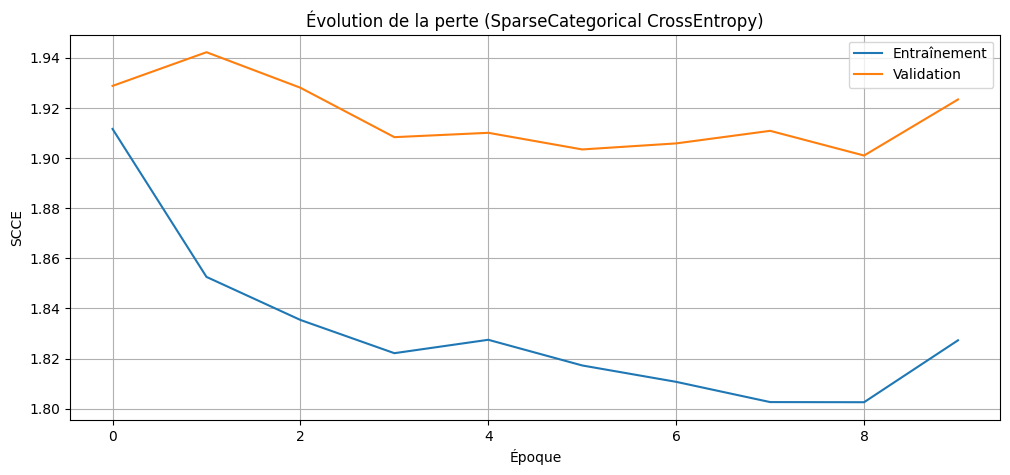

In [38]:
# Courbes d'entraînement et de validation
plt.figure(figsize=(12, 5))
plt.plot(history_lstm.history['loss'], label='Entraînement')
plt.plot(history_lstm.history['val_loss'], label='Validation')
plt.title('Évolution de la perte (SparseCategorical CrossEntropy)')
plt.xlabel('Époque')
plt.ylabel('SCCE')
plt.legend()
plt.grid(True)
plt.show()

Evaluation du modèle LSTM 
Graph de la distribution réelle VS distribution prédite par Bucket 
Permet de regarder si les classes sont prédites avec des poids similaires et équilibrés

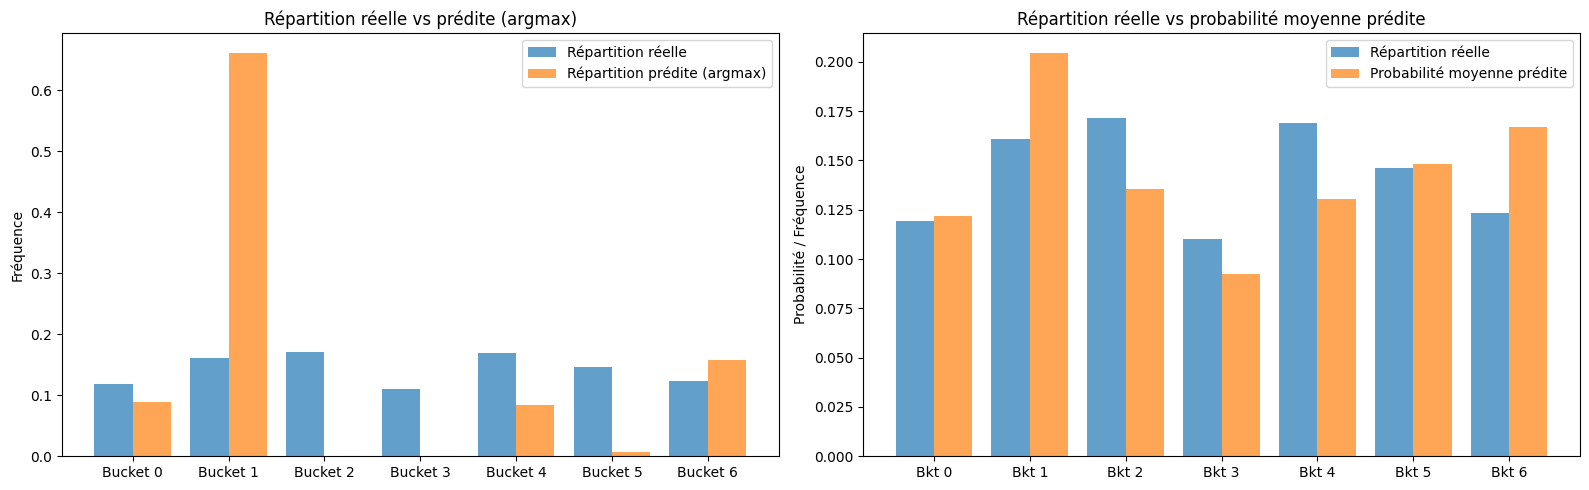

In [32]:
n_buckets = len(true_freq)  
indices = np.arange(n_buckets)
bar_width = 0.4

# Distribution réelle vs Distribution prédite (argmax)
plt.figure(figsize=(16, 5))

# Graphique 1 : Répartition réelle vs prédite (argmax)
plt.subplot(1, 2, 1)
plt.bar(indices - bar_width / 2, true_freq, width=bar_width, alpha=0.7, label="Répartition réelle")
plt.bar(indices + bar_width / 2, pred_freq, width=bar_width, alpha=0.7, label="Répartition prédite (argmax)")
plt.xticks(indices, [f"Bucket {i}" for i in indices])
plt.ylabel("Fréquence")
plt.title("Répartition réelle vs prédite (argmax)")
plt.legend()

# Distribution réelle vs Probabilité moyenne prédite
mean_proba = y_proba.mean(axis=0)  

# Graphique 2 : Répartition réelle vs probabilité moyenne
plt.subplot(1, 2, 2)
plt.bar(indices - bar_width / 2, true_freq, width=bar_width, alpha=0.7, label="Répartition réelle")
plt.bar(indices + bar_width / 2, mean_proba, width=bar_width, alpha=0.7, label="Probabilité moyenne prédite")
plt.xticks(indices, [f"Bkt {i}" for i in indices])
plt.ylabel("Probabilité / Fréquence")
plt.title("Répartition réelle vs probabilité moyenne prédite")
plt.legend()

plt.tight_layout()
plt.show()

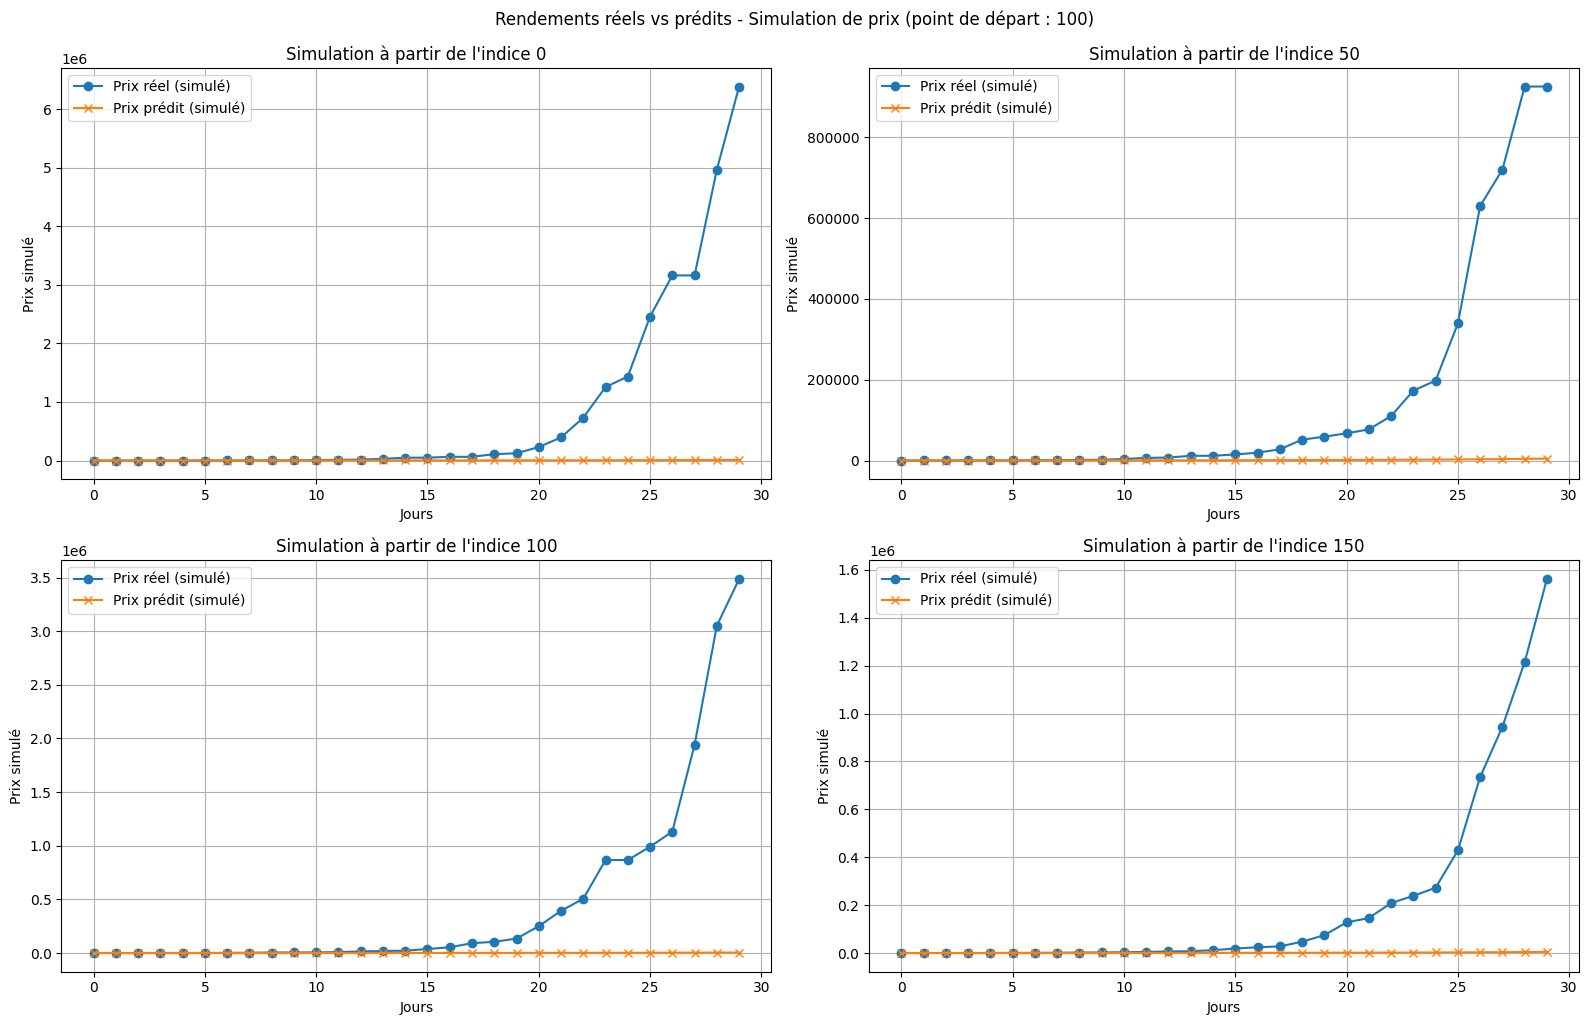

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Simuler les prix avec un point de départ fixe (100) pour comparaison
starting_price = 100
n_days = 30  # Nombre de jours à afficher
sample_indices = [0, 50, 100, 150]  # Indices pour différents points de départ

plt.figure(figsize=(16, 10))

for i, start_idx in enumerate(sample_indices, 1):
    # Récupérer les vraies classes et prédictions pour les jours suivants
    true_returns = y_test_seq[start_idx : start_idx + n_days]
    predicted_returns = predicted_buckets[start_idx : start_idx + n_days]

    # Calcul des prix simulés (basé sur rendement cumulé)
    true_prices = [starting_price]
    predicted_prices = [starting_price]
    for t in range(1, len(true_returns)):
        true_prices.append(true_prices[-1] * (1 + true_returns[t] / n_buckets))  # Échelle relative
        predicted_prices.append(predicted_prices[-1] * (1 + predicted_returns[t] / n_buckets))

    # Sous-graphe
    plt.subplot(2, 2, i)
    plt.plot(range(len(true_prices)), true_prices, label="Prix réel (simulé)", marker='o')
    plt.plot(range(len(predicted_prices)), predicted_prices, label="Prix prédit (simulé)", marker='x')
    plt.title(f"Simulation à partir de l'indice {start_idx}")
    plt.xlabel("Jours")
    plt.ylabel("Prix simulé")
    plt.legend()
    plt.grid(True)

# Mise en page ajustée
plt.tight_layout()
plt.suptitle("Rendements réels vs prédits - Simulation de prix (point de départ : 100)", y=1.02)
plt.show()


# 7) TFT Modèle

In [19]:
class TransformerEncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, x):
        # Multi-head attention
        attn_output = self.mha(x, x, x)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)

        # FFN
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

# PositionalEncoding
class PositionalEncoding(layers.Layer):
    def __init__(self, max_position, d_model):
        super().__init__()
        self.d_model = d_model
        pe = np.zeros((max_position, d_model))
        position = np.arange(0, max_position)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        self.pe = tf.constant(pe, dtype=tf.float32)

    def call(self, x):
        seq_length = tf.shape(x)[1]
        return x + self.pe[:seq_length, :]

# GatedLinearUnit
class GatedLinearUnit(layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.dense = layers.Dense(units)
        self.sigmoid = layers.Dense(units, activation='sigmoid')

    def call(self, inputs):
        return self.dense(inputs) * self.sigmoid(inputs)

# TemporalFusionTransformer pour la classification
class TemporalFusionTransformer:
    def __init__(self, seq_length, num_features,
                 d_model=64, num_heads=4, dff=128, num_layers=2,
                 dropout_rate=0.1, n_buckets=7):
        self.seq_length = seq_length
        self.num_features = num_features
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.n_buckets = n_buckets

    def build_model(self):
        inputs = layers.Input(shape=(self.seq_length, self.num_features))

        x = layers.Dense(self.d_model)(inputs)

        x = PositionalEncoding(self.seq_length, self.d_model)(x)

        for _ in range(self.num_layers):
            x = TransformerEncoderLayer(self.d_model, self.num_heads, self.dff, self.dropout_rate)(x)

        x = layers.GlobalAveragePooling1D()(x)

        x = GatedLinearUnit(self.d_model)(x)

        outputs = layers.Dense(self.n_buckets, activation='softmax')(x)

        model = models.Model(inputs=inputs, outputs=outputs)

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy']
        )
        return model


In [33]:
num_features = X_train_seq.shape[2]


tft = TemporalFusionTransformer(
    seq_length=seq_length,
    num_features=num_features,
    n_buckets=n_buckets   
)
model_TFT = tft.build_model()
model_TFT.summary()

history_TFT = model_TFT.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Évaluation
loss_TFT, acc_TFT = model_TFT.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"\nTFT - Test Cross-Entropy : {loss_TFT:.4f}")
print(f"TFT - Test Accuracy      : {acc_TFT:.2%}")


##########  Sans les indicateurs : TFT - Test Cross-Entropy : 1.8973
#TFT - Test Accuracy      : 18.97%

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 35, 93)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 35, 64)         │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_2           │ (None, 35, 64)         │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_layer_4     │ (None, 35, 64)         │        83,200 │
│ (TransformerEncoderLayer)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_layer_5     │ (None, 35, 64)         │        83,200 │
│ (TransformerEncoderLayer)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_linear_unit_2             │ (None, 64)             │         8,320 │
│ (GatedLinearUnit)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,191 (707.78 KB)

 Trainable params: 181,191 (707.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.2223 - loss: 1.9199 - val_accuracy: 0.1869 - val_loss: 1.9047
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.2434 - loss: 1.8315 - val_accuracy: 0.1735 - val_loss: 1.8988
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.2418 - loss: 1.8158 - val_accuracy: 0.1982 - val_loss: 1.8932
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.2417 - loss: 1.8008 - val_accuracy: 0.1904 - val_loss: 1.8966
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.2515 - loss: 1.7842 - val_accuracy: 0.1932 - val_loss: 1.8975
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 19s 103ms/step - accuracy: 0.2547 - loss: 1.7898 - val_accuracy: 0.1883 - val_loss: 1.8965
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.2544 - loss: 1.7757 - val_accuracy: 0.1939 - val_loss: 1.9010
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.2519 - loss: 1.7747 

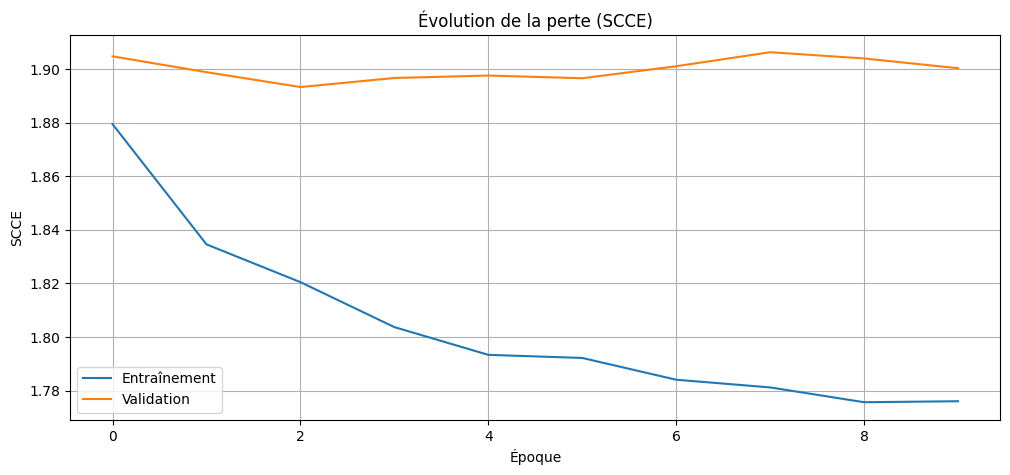

In [35]:
# Courbes d'entraînement et de validation
plt.figure(figsize=(12, 5))
plt.plot(history_TFT.history['loss'], label='Entraînement')
plt.plot(history_TFT.history['val_loss'], label='Validation')
plt.title('Évolution de la perte (SCCE)')
plt.xlabel('Époque')
plt.ylabel('SCCE')
plt.legend()
plt.grid(True)
plt.show()


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


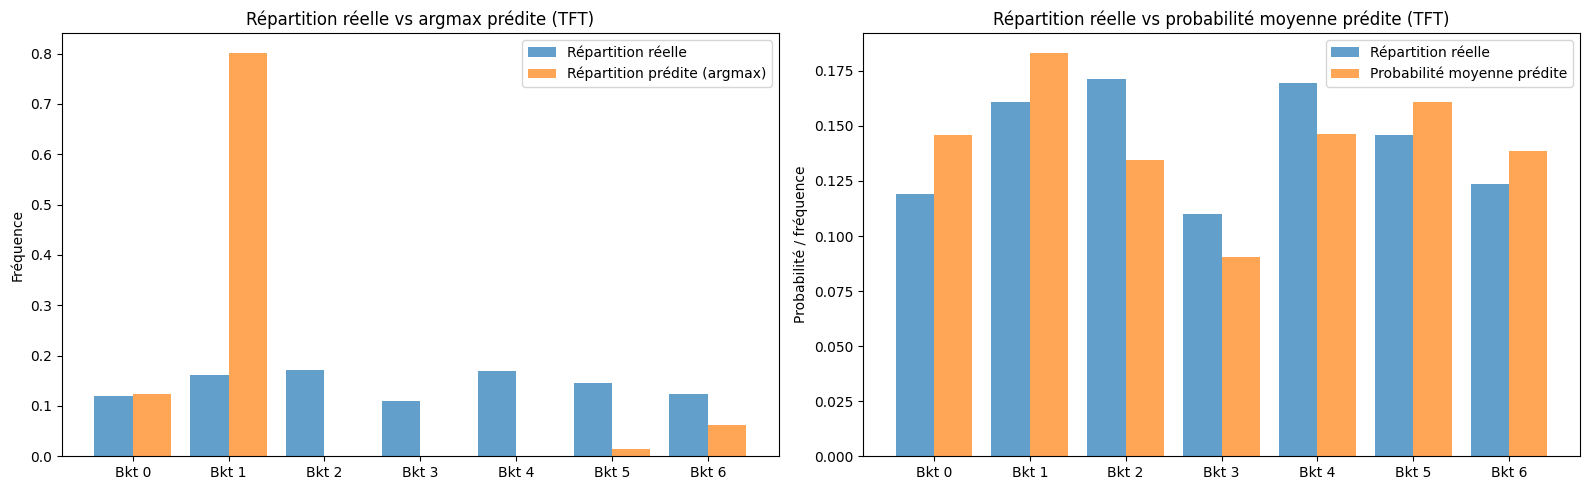

In [34]:
y_proba_TFT = model_TFT.predict(X_test_seq)
y_argmax_TFT = np.argmax(y_proba_TFT, axis=1)

true_counts = np.bincount(y_test_seq, minlength=n_buckets)
pred_counts = np.bincount(y_argmax_TFT, minlength=n_buckets)

true_freq = true_counts / true_counts.sum()
pred_freq = pred_counts / pred_counts.sum()

indices = np.arange(n_buckets)
bar_width = 0.4

mean_proba = y_proba_TFT.mean(axis=0)  # Moyenne des probabilités

# Création d'une figure avec deux graphiques côte à côte
plt.figure(figsize=(16, 5))

# Graphique 1 : Répartition réelle vs Répartition prédite (argmax)
plt.subplot(1, 2, 1)
plt.bar(indices - bar_width / 2, true_freq, width=bar_width, alpha=0.7, label="Répartition réelle")
plt.bar(indices + bar_width / 2, pred_freq, width=bar_width, alpha=0.7, label="Répartition prédite (argmax)")
plt.xticks(indices, [f"Bkt {i}" for i in indices])
plt.ylabel("Fréquence")
plt.title("Répartition réelle vs argmax prédite (TFT)")
plt.legend()

# Graphique 2 : Répartition réelle vs Probabilité moyenne prédite
plt.subplot(1, 2, 2)
plt.bar(indices - bar_width / 2, true_freq, width=bar_width, alpha=0.7, label="Répartition réelle")
plt.bar(indices + bar_width / 2, mean_proba, width=bar_width, alpha=0.7, label="Probabilité moyenne prédite")
plt.xticks(indices, [f"Bkt {i}" for i in indices])
plt.ylabel("Probabilité / fréquence")
plt.title("Répartition réelle vs probabilité moyenne prédite (TFT)")
plt.legend()

# Ajustement de la mise en page
plt.tight_layout()
plt.show()


# 8) Ajout d'indices financiers et comparaison 

Features engineering pour le modèle TFT on va ajouter des features :

-RSI 
-MACD 
-Bande de Bollinger 
-Momentum et Rate Of Change (ROC)

In [24]:
df_full = df_seq.copy()

# Ajout des indicateurs techniques
df_full["RSI_14"] = ta.rsi(df_full["Price"], length=14)

# Ajout du MACD
macd = ta.macd(df_full["Price"])
df_full["MACD"] = macd["MACD_12_26_9"]
df_full["MACD_Signal"] = macd["MACDs_12_26_9"]
df_full["MACD_Hist"] = macd["MACDh_12_26_9"]

# Ajout des Bandes de Bollinger
bbands = ta.bbands(df_full["Price"], length=20, std=2)
df_full["BB_Lower"] = bbands["BBL_20_2.0"]
df_full["BB_Mid"] = bbands["BBM_20_2.0"]
df_full["BB_Upper"] = bbands["BBU_20_2.0"]

# Ajout du Momentum et du ROC (Rate of Change)
df_full["Momentum_5"] = ta.mom(df_full["Price"], length=5) 
df_full["ROC_5"] = ta.roc(df_full["Price"], length=5)     


# Suppression des lignes NaN
df_full.dropna(inplace=True)

# Vérification et correction des types des colonnes (si nécessaire)
for col in ["RSI_14", "MACD", "MACD_Signal", "MACD_Hist", "BB_Lower", "BB_Mid", "BB_Upper", "Momentum_5", "ROC_5"]:
    df_full[col] = pd.to_numeric(df_full[col], errors='coerce')

# Suppression des lignes NaN après correction
df_full.dropna(inplace=True)


cuts_full = df_full['FutureReturn'].quantile(quantiles).values

print("Cut edges (quantiles):", cuts_full)

df_full['FutureReturn_bucket'] = pd.cut(
    df_full['FutureReturn'],
    bins=cuts_full,            
    labels=False,         
    include_lowest=True   
)


exclude_cols_full = ["Price", "Return", "FutureReturn", "FutureReturn_bucket"]
feature_cols_full = [c for c in df_full.columns if c not in exclude_cols_full]
X_full = df_full[feature_cols_full].values
y_full = df_full["FutureReturn_bucket"].values.astype(int)  

N_full = len(df_full)
Nt_full = int(0.8 * N_full)
Nv_full = N_full - Nt_full

X_train_full, X_test_full = X_full[:Nt_full], X_full[Nt_full:]
y_train_full, y_test_full = y_full[:Nt_full], y_full[Nt_full:]
scaler_full = StandardScaler()
X_train_scaled_full = scaler_full.fit_transform(X_train_full)
X_test_scaled_full  = scaler_full.transform(X_test_full)

seq_length = 35

X_train_seq_full, y_train_seq_full = create_sequences(X_train_scaled_full, y_train_full, seq_length)
X_test_seq_full,  y_test_seq_full  = create_sequences(X_test_scaled_full,  y_test_full,  seq_length)

print(f"Forme X_train_seq_full : {X_train_seq_full.shape}")
print(f"Forme y_train_seq_full : {y_train_seq_full.shape}")

y_train_cat_full = to_categorical(y_train_seq_full, num_classes=n_buckets)
y_test_cat_full  = to_categorical(y_test_seq_full,  num_classes=n_buckets)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False) 

Cut edges (quantiles): [-0.19116565 -0.01851826 -0.00823029 -0.00171468  0.0020003   0.00864756
  0.0193249   0.18874477]
Forme X_train_seq_full : (5748, 35, 102)
Forme y_train_seq_full : (5748,)


In [37]:
num_features_full = X_train_seq_full.shape[2]


tft_full = TemporalFusionTransformer(
    seq_length=seq_length,
    num_features=num_features_full,
    n_buckets=n_buckets   
)
model_TFT_full = tft_full.build_model()

history_TFT_full = model_TFT_full.fit(
    X_train_seq_full, y_train_seq_full,
    validation_data=(X_test_seq_full, y_test_seq_full),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Évaluation
loss_TFT_full, acc_TFT_full = model_TFT_full.evaluate(X_test_seq_full, y_test_seq_full, verbose=0)
print(f"\nTFT - Test Cross-Entropy : {loss_TFT_full:.4f}")
print(f"TFT - Test Accuracy      : {acc_TFT_full:.2%}")


Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 31s 105ms/step - accuracy: 0.2089 - loss: 1.9346 - val_accuracy: 0.1942 - val_loss: 1.9008
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.2329 - loss: 1.8519 - val_accuracy: 0.1942 - val_loss: 1.8999
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.2279 - loss: 1.8448 - val_accuracy: 0.1984 - val_loss: 1.8883
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.2273 - loss: 1.8072 - val_accuracy: 0.1963 - val_loss: 1.8831
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.2332 - loss: 1.7995 - val_accuracy: 0.1899 - val_loss: 1.8854
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.2405 - loss: 1.7996 - val_accuracy: 0.1892 - val_loss: 1.8859
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.2415 - loss: 1.7911 - val_accuracy: 0.1914 - val_loss: 1.8857
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.2399 - loss: 1.7879

In [ ]:
model_lstm_full = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length, X_train_seq_full.shape[2])),
    tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(64, return_sequences=False, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(n_buckets, activation='softmax')  
])

model_lstm_full.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


history_lstm_full = model_lstm_full.fit(
    X_train_seq_full, y_train_seq_full,
    validation_data=(X_test_seq_full, y_test_seq_full),
    epochs=10,
    batch_size=32,
    verbose=1
)

loss_lstm_full, acc_lstm_full = model_lstm_full.evaluate(X_test_seq_full, y_test_seq_full, verbose=0)
print(f"\nTest loss (cross-entropy) : {loss_lstm_full:.4f}")
print(f"Test accuracy             : {acc_TFT_full:.2%}")
#y_proba = model_lstm.predict(X_test_seq)
#predicted_buckets = np.argmax(y_proba, axis=1)

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.1944 - loss: 1.9758 - val_accuracy: 0.1878 - val_loss: 1.9330
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.2302 - loss: 1.8727 - val_accuracy: 0.1701 - val_loss: 1.9132
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.2364 - loss: 1.8586 - val_accuracy: 0.1758 - val_loss: 1.9083
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.2480 - loss: 1.8397 - val_accuracy: 0.1828 - val_loss: 1.9154
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.2473 - loss: 1.8312 - val_accuracy: 0.1609 - val_loss: 1.9289
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.2410 - loss: 1.8270 - val_accuracy: 0.1942 - val_loss: 1.9109
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.2456 - loss: 1.8245 - val_accuracy: 0.1651 - val_loss: 1.9533
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.2551 - loss: 1.8172 - val